In [1]:
import sys
sys.path.append('../src/')

from simulations import generate_ideal_points

ideal_points, df, word_matrix, beta, label_coeffs = generate_ideal_points(
    num_politicians=10000,
    dim_ideal_points=1,
    num_covs=0,
    num_bills=500,
    num_survey_questions=100,
    doc_length=100,
    vocab_size=500,
    label_type="regression",
    progress_bar=True
)

Surveys: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.23it/s]


In [2]:
from corpus import Corpus

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()  
vectorizer.fit(df["doc_clean"])

modalities = {
    "text": {
        "column": "doc_clean",
        "views": {
            "bow": {
                "type": "bow",
                "vectorizer": vectorizer
            }
        }
    },
    "vote": {
        "column": [f"vote_{i+1}" for i in range(500)],
        "views": {
            "responses": {
                "type": "vote"
            }
        }
    },
    "survey": {
        "column": [f"Q_{i+1}" for i in range(100)],
        "views": {
            "responses": {
                "type": "discrete_choice"
            }
        }
    }
}

full_dataset = Corpus(
    df,
    modalities=modalities
)

In [3]:
from models import IdealPointNN

encoder_args = {
    "text_bow": {
        "hidden_dims": [128,64],
        "activation": "relu",
        "bias": True,
        "dropout": 0.0
    },
    "vote_responses": {
        "hidden_dims": [128,64],
        "activation": "relu",
        "bias": True,
        "dropout": 0.0
    }
}

decoder_args = {
    "text_bow": {
        "hidden_dims": [64,128],
        "activation": "relu",
        "bias": True,
        "dropout": 0.0
    },
    "vote_responses": {
        "hidden_dims": [64,128],
        "activation": "relu",
        "bias": True,
        "dropout": 0.0
    }
}

m = IdealPointNN(
    ae_type="vae",
    n_ideal_points=1,
    train_data=full_dataset,
    encoder_args=encoder_args,
    decoder_args=decoder_args,
    print_every_n_epochs=1,
    patience=3,
    w_prior=1,
    fusion="poe"
)


Epoch   1	Mean Training Loss:6.7732249


Epoch   2	Mean Training Loss:6.7511758


Epoch   3	Mean Training Loss:6.7631393


Epoch   4	Mean Training Loss:6.7761236


Epoch   5	Mean Training Loss:6.7887925


Stopping at Epoch 5. Reverting to Epoch 2


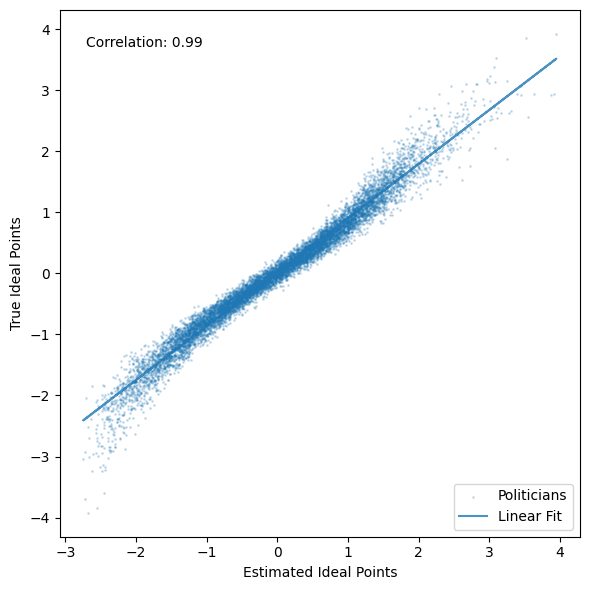

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Get estimated ideal points (shape: [N, 1])
estimated = m.get_ideal_points(
    full_dataset, 
    num_samples=30
)

# True ideal points from the simulation (shape: [N, D])
true = ideal_points[:, 0]  # Assuming 1D ideal points, take column 0

# Flatten for plotting
x = estimated.flatten()
y = true.flatten()  # Optional sign correction to align orientation

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(x, y, label='Politicians', s=1, alpha=0.2)

# Linear fit
coefficients = np.polyfit(x, y, 1)
fit_fn = np.poly1d(coefficients)
plt.plot(x, fit_fn(x), label='Linear Fit', alpha=0.8)

# Correlation coefficient
corr = np.corrcoef(x, y)[0, 1]

# Labels
plt.xlabel('Estimated Ideal Points')
plt.ylabel('True Ideal Points')
plt.legend()

# Correlation display
plt.text(0.05, 0.95, f'Correlation: {corr:.2f}',
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top')

# Layout and save
plt.tight_layout()
plt.show()

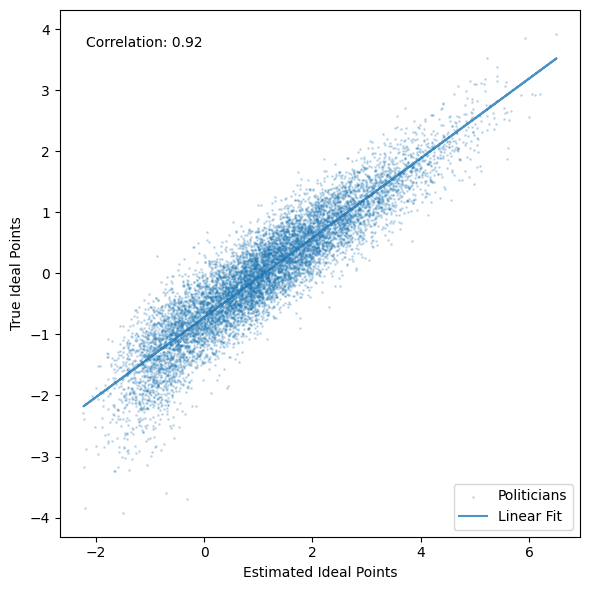

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Get estimated ideal points (shape: [N, 1])
estimated = m.get_ideal_points(
    full_dataset, 
    single_modality="text_bow", 
    num_samples=30
)

# True ideal points from the simulation (shape: [N, D])
true = ideal_points[:, 0]  # Assuming 1D ideal points, take column 0

# Flatten for plotting
x = estimated.flatten()
y = true.flatten()  # Optional sign correction to align orientation

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(x, y, label='Politicians', s=1, alpha=0.2)

# Linear fit
coefficients = np.polyfit(x, y, 1)
fit_fn = np.poly1d(coefficients)
plt.plot(x, fit_fn(x), label='Linear Fit', alpha=0.8)

# Correlation coefficient
corr = np.corrcoef(x, y)[0, 1]

# Labels
plt.xlabel('Estimated Ideal Points')
plt.ylabel('True Ideal Points')
plt.legend()

# Correlation display
plt.text(0.05, 0.95, f'Correlation: {corr:.2f}',
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top')

# Layout and save
plt.tight_layout()
plt.show()

In [6]:
# How much does each modality contribute (on average)?
# Text is much noisier, so the model puts much more weight on votes.

weights = m.get_modality_weights(full_dataset)
modality_names = list(m.encoder.encoders.keys())  # e.g., ['text_bow', 'vote_responses']

# Average contribution per modality
import pandas as pd

df_weights = pd.DataFrame(weights, columns=modality_names)
summary = pd.DataFrame({
    "mean": df_weights.mean(),
    "std": df_weights.std()
}).sort_values("mean", ascending=False)

print(summary)

                    mean       std
vote_responses  0.918448  0.063227
text_bow        0.081553  0.063227
